In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import pickle as pk

In [2]:
def weighted_mean_std(values, errors):

    #If errors are zero make them just a bit bigger
    errors = np.array(errors) + 10**-5#np.where(errors == 0, , errors)
    
    # Calculate the weights
    weights = 1 / np.square(errors)
    
    # Calculate the weighted mean
    weighted_mean = np.sum(weights * values) / np.sum(weights)

    # Calculate the weighted variance
    weighted_variance = np.sum(weights * (values - weighted_mean)**2) / np.sum(weights)
    
    # Calculate the weighted standard deviation
    weighted_std = np.sqrt(weighted_variance)

    return weighted_mean, weighted_std

## DATA CONCATENATION

In [35]:
# Initialize lists to store concatenated results
final_result_matricesConcat = []

# Iterate through combinations of RESTRICTED_CASE and WITHIN_CASE
for RESTRICTED_CASE, WITHIN_CASE in [(False, True), (False, False)]:
    # Determine case label
    case = "WITHIN" if WITHIN_CASE else "BETWEEN"
    if RESTRICTED_CASE:
        case += "_RESTRICTED"
    
    # Define file paths
    file_paths = {
        "final_result_matrices": f"./OUTPUT/{case}_final_result_matrices.npy",
    }
    
    # Check and load data
    for key, path in file_paths.items():
        if os.path.exists(path):
            data = np.load(path, allow_pickle=True)
            eval(f'{key}Concat').append(data)
        else:
            print(f"File {path} does not exist. Skipping this file.")

# Concatenate data
final_result_matricesConcat = np.concatenate(final_result_matricesConcat) if final_result_matricesConcat else np.array([])

# Print confirmation
print("Data concatenation complete.")


Data concatenation complete.


In [36]:
np.shape(final_result_matricesConcat)

(12343, 100)

## DATA CLEAN

In [37]:
#Find all the indices where the starting position is above 150
indices = np.where(final_result_matricesConcat[:,50] > 150)[0]

In [42]:
#Remove from all the arrays the indices
final_result_matricesConcat = np.delete(final_result_matricesConcat, indices, axis = 0)

## PCA

In [104]:
CUTOFF = 0
LENGTH = 50
final_result_matricesConcat2 = []
for index in range(len(final_result_matricesConcat)):
    X = final_result_matricesConcat[index, :LENGTH - CUTOFF]
    Y = final_result_matricesConcat[index, LENGTH: 2*LENGTH - CUTOFF]
    final_result_matricesConcat2.append(np.concatenate((X, Y)))

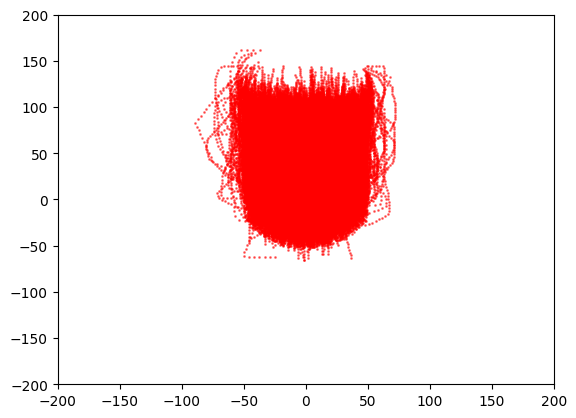

In [105]:
LENGTH -= CUTOFF
Ys = [trajectory[LENGTH:] for trajectory in final_result_matricesConcat2]
Xs = [trajectory[:LENGTH] for trajectory in final_result_matricesConcat2]

plt.scatter(Xs, Ys, c='r', label='X', alpha=0.5, s=1)
#plt.axis('equal')
plt.xlim(-200, 200)
plt.ylim(-200, 200)
plt.show()

In [121]:
# Perform PCA on the result matrices
pca = PCA(n_components=10)
pca.fit(final_result_matricesConcat2)
nComponents = 10
pca_result = pca.transform(final_result_matricesConcat2)[:, :nComponents]
pca_coefficients = pca.components_
pca_explained_variance = pca.explained_variance_ratio_

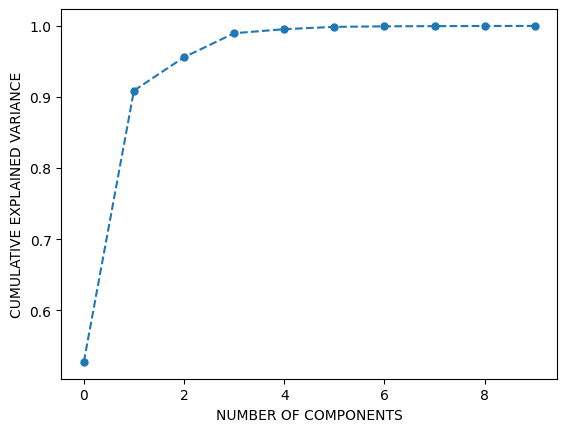

In [122]:
#PLot the explained variance
plt.plot(np.cumsum(pca_explained_variance), "--o", markersize=5)
plt.xlabel('NUMBER OF COMPONENTS')
plt.ylabel('CUMULATIVE EXPLAINED VARIANCE')
plt.savefig('PCA_explained_variance.png', dpi=300)
plt.show()

In [123]:
np.cumsum(pca.explained_variance_ratio_)

array([0.52757622, 0.90886059, 0.95574596, 0.98951566, 0.99522413,
       0.99847262, 0.99922664, 0.99949326, 0.99970926, 0.99979149])

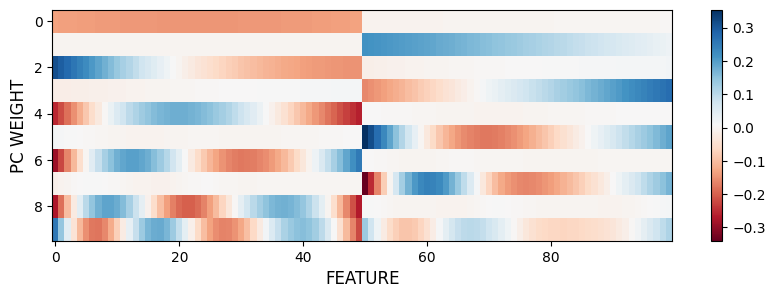

In [127]:
#Compose the images in a 2x2 grid with letters A, B, C, D
fig, ax = plt.subplots(1, figsize=(10,3))
# Adjust the figure margins to minimize space
#plt.margins(0, 0)
im0 = ax.imshow(pca_coefficients[:nComponents], interpolation='nearest', cmap=plt.cm.RdBu,aspect='auto')
ax.set_xlabel('FEATURE', fontsize = 12)
ax.set_ylabel('PC WEIGHT', fontsize = 12)
#ax.set_title('PCA COEFFICIENTS', fontsize = 20)
plt.colorbar(im0)
plt.savefig('PCA_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()

In [110]:
#Save the PCA fitted model with pickle
with open('./OUTPUT/pca_model.pkl', 'wb') as f:
    pk.dump(pca, f)